<a href="https://colab.research.google.com/github/KoreTane/interesting/blob/main/ClusterC_2024_12_18_22_31_48.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import seaborn as sns
files = {
    "df": "dbfs:/FileStore/tables/clusterizacao/online_retail_II.csv"
}
df = spark.read.csv(files["df"], inferSchema=True, header=True)
df.printSchema()
df.describe().show(truncate=False)
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()


root
 |-- Invoice: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- Price: double (nullable = true)
 |-- Customer ID: double (nullable = true)
 |-- Country: string (nullable = true)

+-------+-----------------+------------------+-----------------------------------+------------------+------------------+------------------+-----------+
|summary|Invoice          |StockCode         |Description                        |Quantity          |Price             |Customer ID       |Country    |
+-------+-----------------+------------------+-----------------------------------+------------------+------------------+------------------+-----------+
|count  |1067371          |1067371           |1062989                            |1067371           |1067371           |824364            |1067371    |
|mean   |537608.1499316233|29011.161534536903|21848.25   

In [ ]:
df = df.fillna({'Description': 'No description'})
df = df.fillna({'Customer ID': -1})

+-------+---------+-----------+--------+-----------+-----+-----------+-------+
|Invoice|StockCode|Description|Quantity|InvoiceDate|Price|Customer ID|Country|
+-------+---------+-----------+--------+-----------+-----+-----------+-------+
|      0|        0|          0|       0|          0|    0|          0|      0|
+-------+---------+-----------+--------+-----------+-----+-----------+-------+

+-------+-----------------+------------------+-----------------------------------+------------------+------------------+------------------+-----------+
|summary|Invoice          |StockCode         |Description                        |Quantity          |Price             |Customer ID       |Country    |
+-------+-----------------+------------------+-----------------------------------+------------------+------------------+------------------+-----------+
|count  |1067371          |1067371           |1067371                            |1067371           |1067371           |1067371           |1067371  

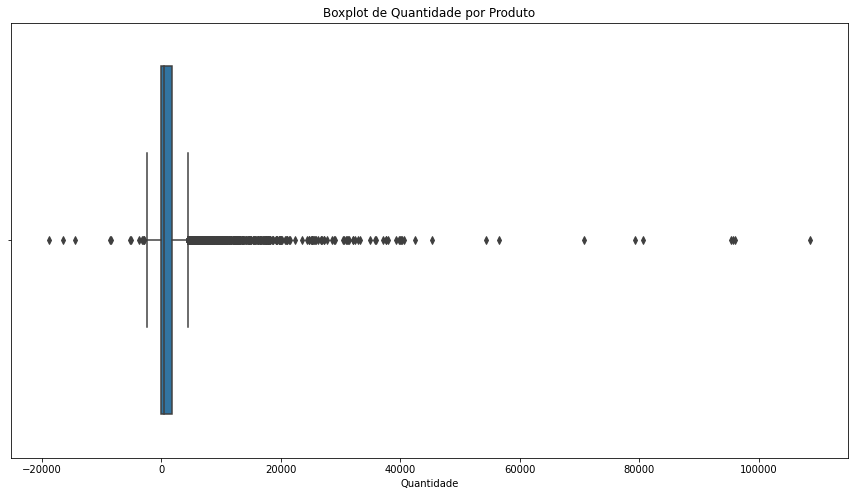

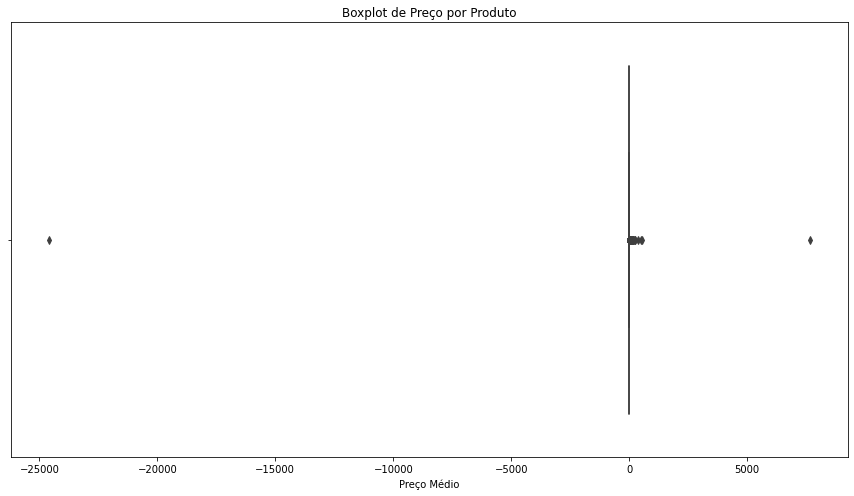

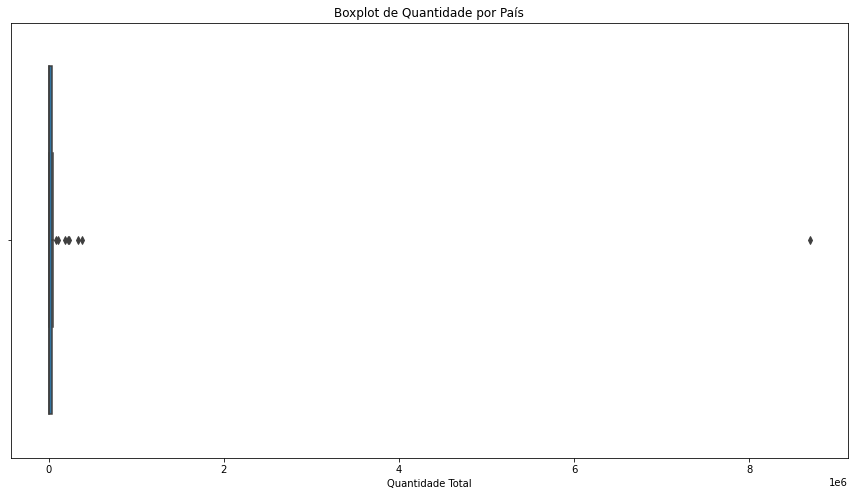

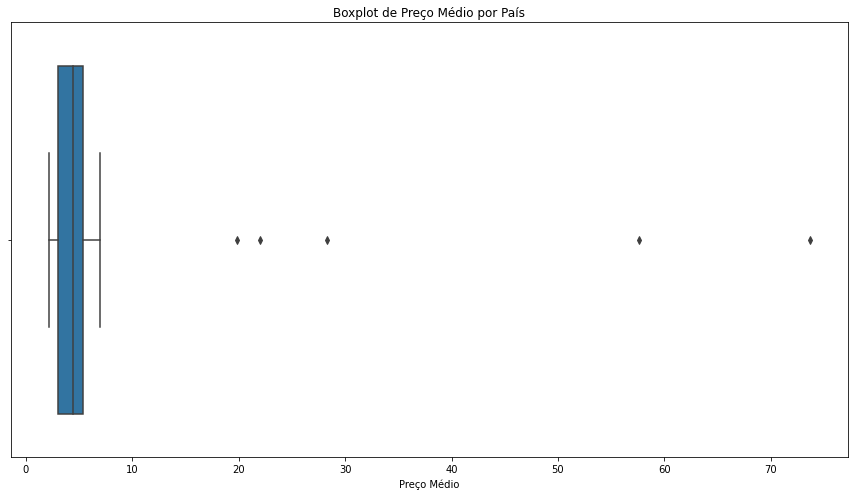

In [ ]:


# Converter colunas para Pandas para visualização
quantity_by_product = df.groupBy("StockCode").sum("Quantity").toPandas()
price_by_product = df.groupBy("StockCode").avg("Price").toPandas()
quantity_price_by_country = df.groupBy("Country").agg(sum("Quantity").alias("TotalQuantity"), avg("Price").alias("AvgPrice")).toPandas()

# Boxplot de Quantidade por Produto
plt.figure(figsize=(15, 8))
sns.boxplot(x=quantity_by_product["sum(Quantity)"])
plt.title("Boxplot de Quantidade por Produto")
plt.xlabel("Quantidade")
plt.show()

# Boxplot de Preço por Produto
plt.figure(figsize=(15, 8))
sns.boxplot(x=price_by_product["avg(Price)"])
plt.title("Boxplot de Preço por Produto")
plt.xlabel("Preço Médio")
plt.show()

# Boxplot de Quantidade por País
plt.figure(figsize=(15, 8))
sns.boxplot(x=quantity_price_by_country["TotalQuantity"])
plt.title("Boxplot de Quantidade por País")
plt.xlabel("Quantidade Total")
plt.show()

# Boxplot de Preço por País
plt.figure(figsize=(15, 8))
sns.boxplot(x=quantity_price_by_country["AvgPrice"])
plt.title("Boxplot de Preço Médio por País")
plt.xlabel("Preço Médio")
plt.show()


In [ ]:
# Calcular Q1 e Q3 para Price
price_quartiles = df.approxQuantile("Price", [0.25, 0.75], 0.05)
price_q1 = price_quartiles[0]
price_q3 = price_quartiles[1]
price_iqr = price_q3 - price_q1
price_lower_bound = price_q1 - 1.5 * price_iqr
price_upper_bound = price_q3 + 1.5 * price_iqr

# Calcular Q1 e Q3 para Quantity
quantity_quartiles = df.approxQuantile("Quantity", [0.25, 0.75], 0.05)
quantity_q1 = quantity_quartiles[0]
quantity_q3 = quantity_quartiles[1]
quantity_iqr = quantity_q3 - quantity_q1
quantity_lower_bound = quantity_q1 - 1.5 * quantity_iqr
quantity_upper_bound = quantity_q3 + 1.5 * quantity_iqr

# Contar valores fora do intervalo para Price
outliers_price_count = df.filter((col("Price") < price_lower_bound) | (col("Price") > price_upper_bound)).count()

# Contar valores fora do intervalo para Quantity
outliers_quantity_count = df.filter((col("Quantity") < quantity_lower_bound) | (col("Quantity") > quantity_upper_bound)).count()

# Mostrar resultados
print("Valores fora do intervalo para Price:", outliers_price_count)
print("Valores fora do intervalo para Quantity:", outliers_quantity_count)


Valores fora do intervalo para Price: 85242
Valores fora do intervalo para Quantity: 116489


In [ ]:
# Agrupar por ano
df.groupBy(year("InvoiceDate").alias("Ano")).count().show()

# Agrupar por mês
df.groupBy(month("InvoiceDate").alias("Mês")).count().show()

# Agrupar por dia do mês
df.groupBy(dayofmonth("InvoiceDate").alias("Dia")).count().show()

# Agrupar por país
df.groupBy("Country").count().orderBy("count", ascending=False).show()

# Agrupar por StockCode e Description
df.groupBy("StockCode", "Description").agg(sum("Quantity").alias("TotalQuantity"), sum("Price").alias("TotalPrice")).orderBy("TotalQuantity", ascending=False).show()

# Agrupar por Customer ID
df.groupBy("Customer ID").agg(countDistinct("Invoice").alias("TotalOrders"), sum("Price").alias("TotalSpent")).orderBy("TotalSpent", ascending=False).show()

# Calcular a correlação entre Quantity e Price
df.select("Quantity", "Price").corr("Quantity", "Price")


+----+------+
| Ano| count|
+----+------+
|2009| 45228|
|2010|522714|
|2011|499429|
+----+------+

+---+------+
|Mês| count|
+---+------+
| 12|135758|
|  1| 66702|
|  3| 78259|
|  2| 57095|
|  6| 76857|
|  5| 72353|
|  4| 63973|
|  7| 72901|
|  9| 92317|
|  8| 68590|
| 10|119840|
| 11|162726|
+---+------+

+---+-----+
|Dia|count|
+---+-----+
| 31|18289|
| 28|35050|
| 26|28224|
| 27|27831|
| 12|29278|
| 22|35006|
|  1|37236|
| 13|32782|
|  6|40336|
| 16|33726|
|  3|31756|
| 20|31451|
|  5|39021|
| 19|32322|
| 15|33867|
|  9|36391|
| 17|39269|
|  4|37247|
|  8|45961|
| 23|32502|
+---+-----+
only showing top 20 rows

+---------------+------+
|        Country| count|
+---------------+------+
| United Kingdom|981330|
|           EIRE| 17866|
|        Germany| 17624|
|         France| 14330|
|    Netherlands|  5140|
|          Spain|  3811|
|    Switzerland|  3189|
|        Belgium|  3123|
|       Portugal|  2620|
|      Australia|  1913|
|Channel Islands|  1664|
|          Italy|  1534|
|  